In [1]:
import re
import random
import json
from collections import defaultdict
from datasets import load_dataset

dataset = load_dataset("gsm8k", "socratic", split="train")
print(len(dataset))  # ~7.4k

dataset

7473


Dataset({
    features: ['question', 'answer'],
    num_rows: 7473
})

Loading GSM8K dataset...
Total samples: 7473

Annotating dataset...
Annotation complete: 7473 questions

=== FULL DATASET ANALYSIS ===

Step distribution:
  2 steps: 1960
  3 steps: 2149
  4 steps: 1660
  5 steps: 954
  6 steps: 419
  7 steps: 228
  8 steps: 90
  9 steps: 13

Concept distribution:
  time: 2552
  arithmetic: 1622
  percentage: 1060
  money: 1057
  fraction: 597
  ratio: 252
  geometry: 229
  algebra: 100
  probability: 4

Schema distribution:
  repeated_groups: 3909
  sequential: 1054
  multi_step: 973
  aggregation: 875
  comparison: 384
  rate: 278
✓ Saved: visualizations/full_dataset_overview.png
✓ Saved: visualizations/full_dataset_heatmap.png

=== SELECTING 200 DIVERSE QUESTIONS ===

Selected: 200 questions

Selected distribution:
  Steps: {2: 16, 3: 24, 4: 38, 5: 22, 6: 35, 7: 15, 8: 43, 9: 7}
  Concepts: {'time': 30, 'money': 28, 'fraction': 25, 'percentage': 25, 'arithmetic': 24}
  Schemas: {'repeated_groups': 110, 'sequential': 26, 'aggregation': 25, 'multi_ste

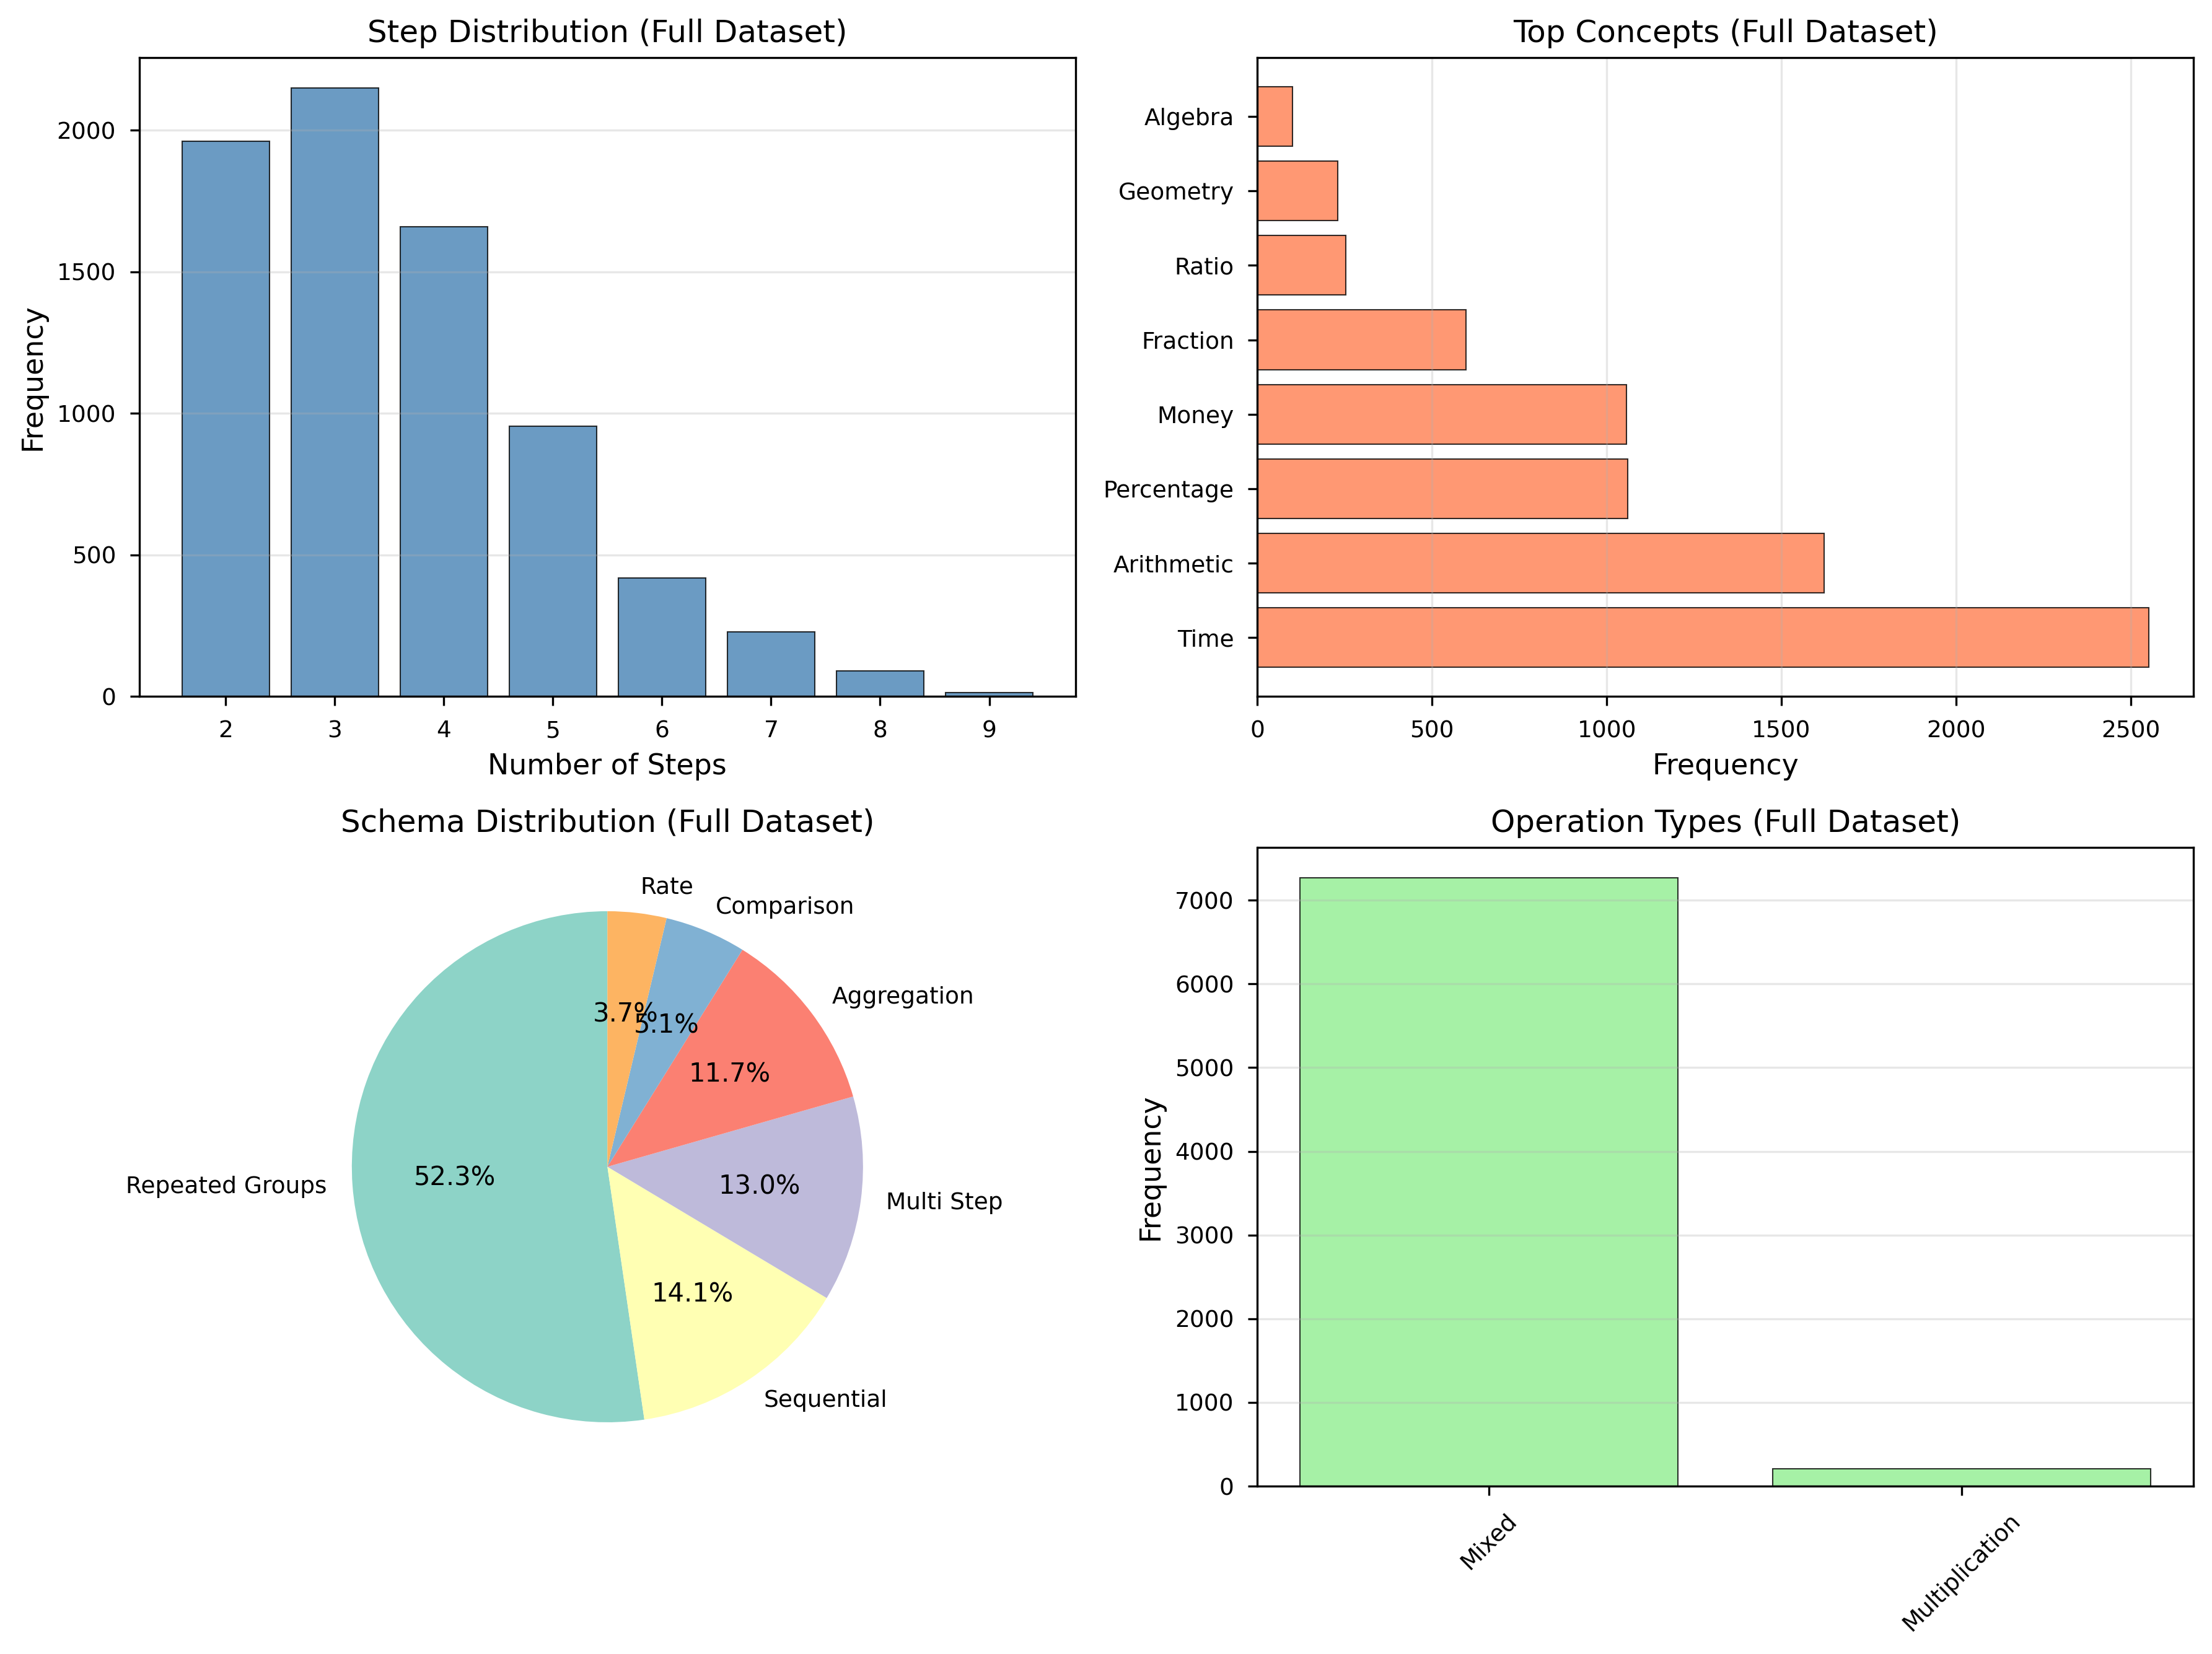

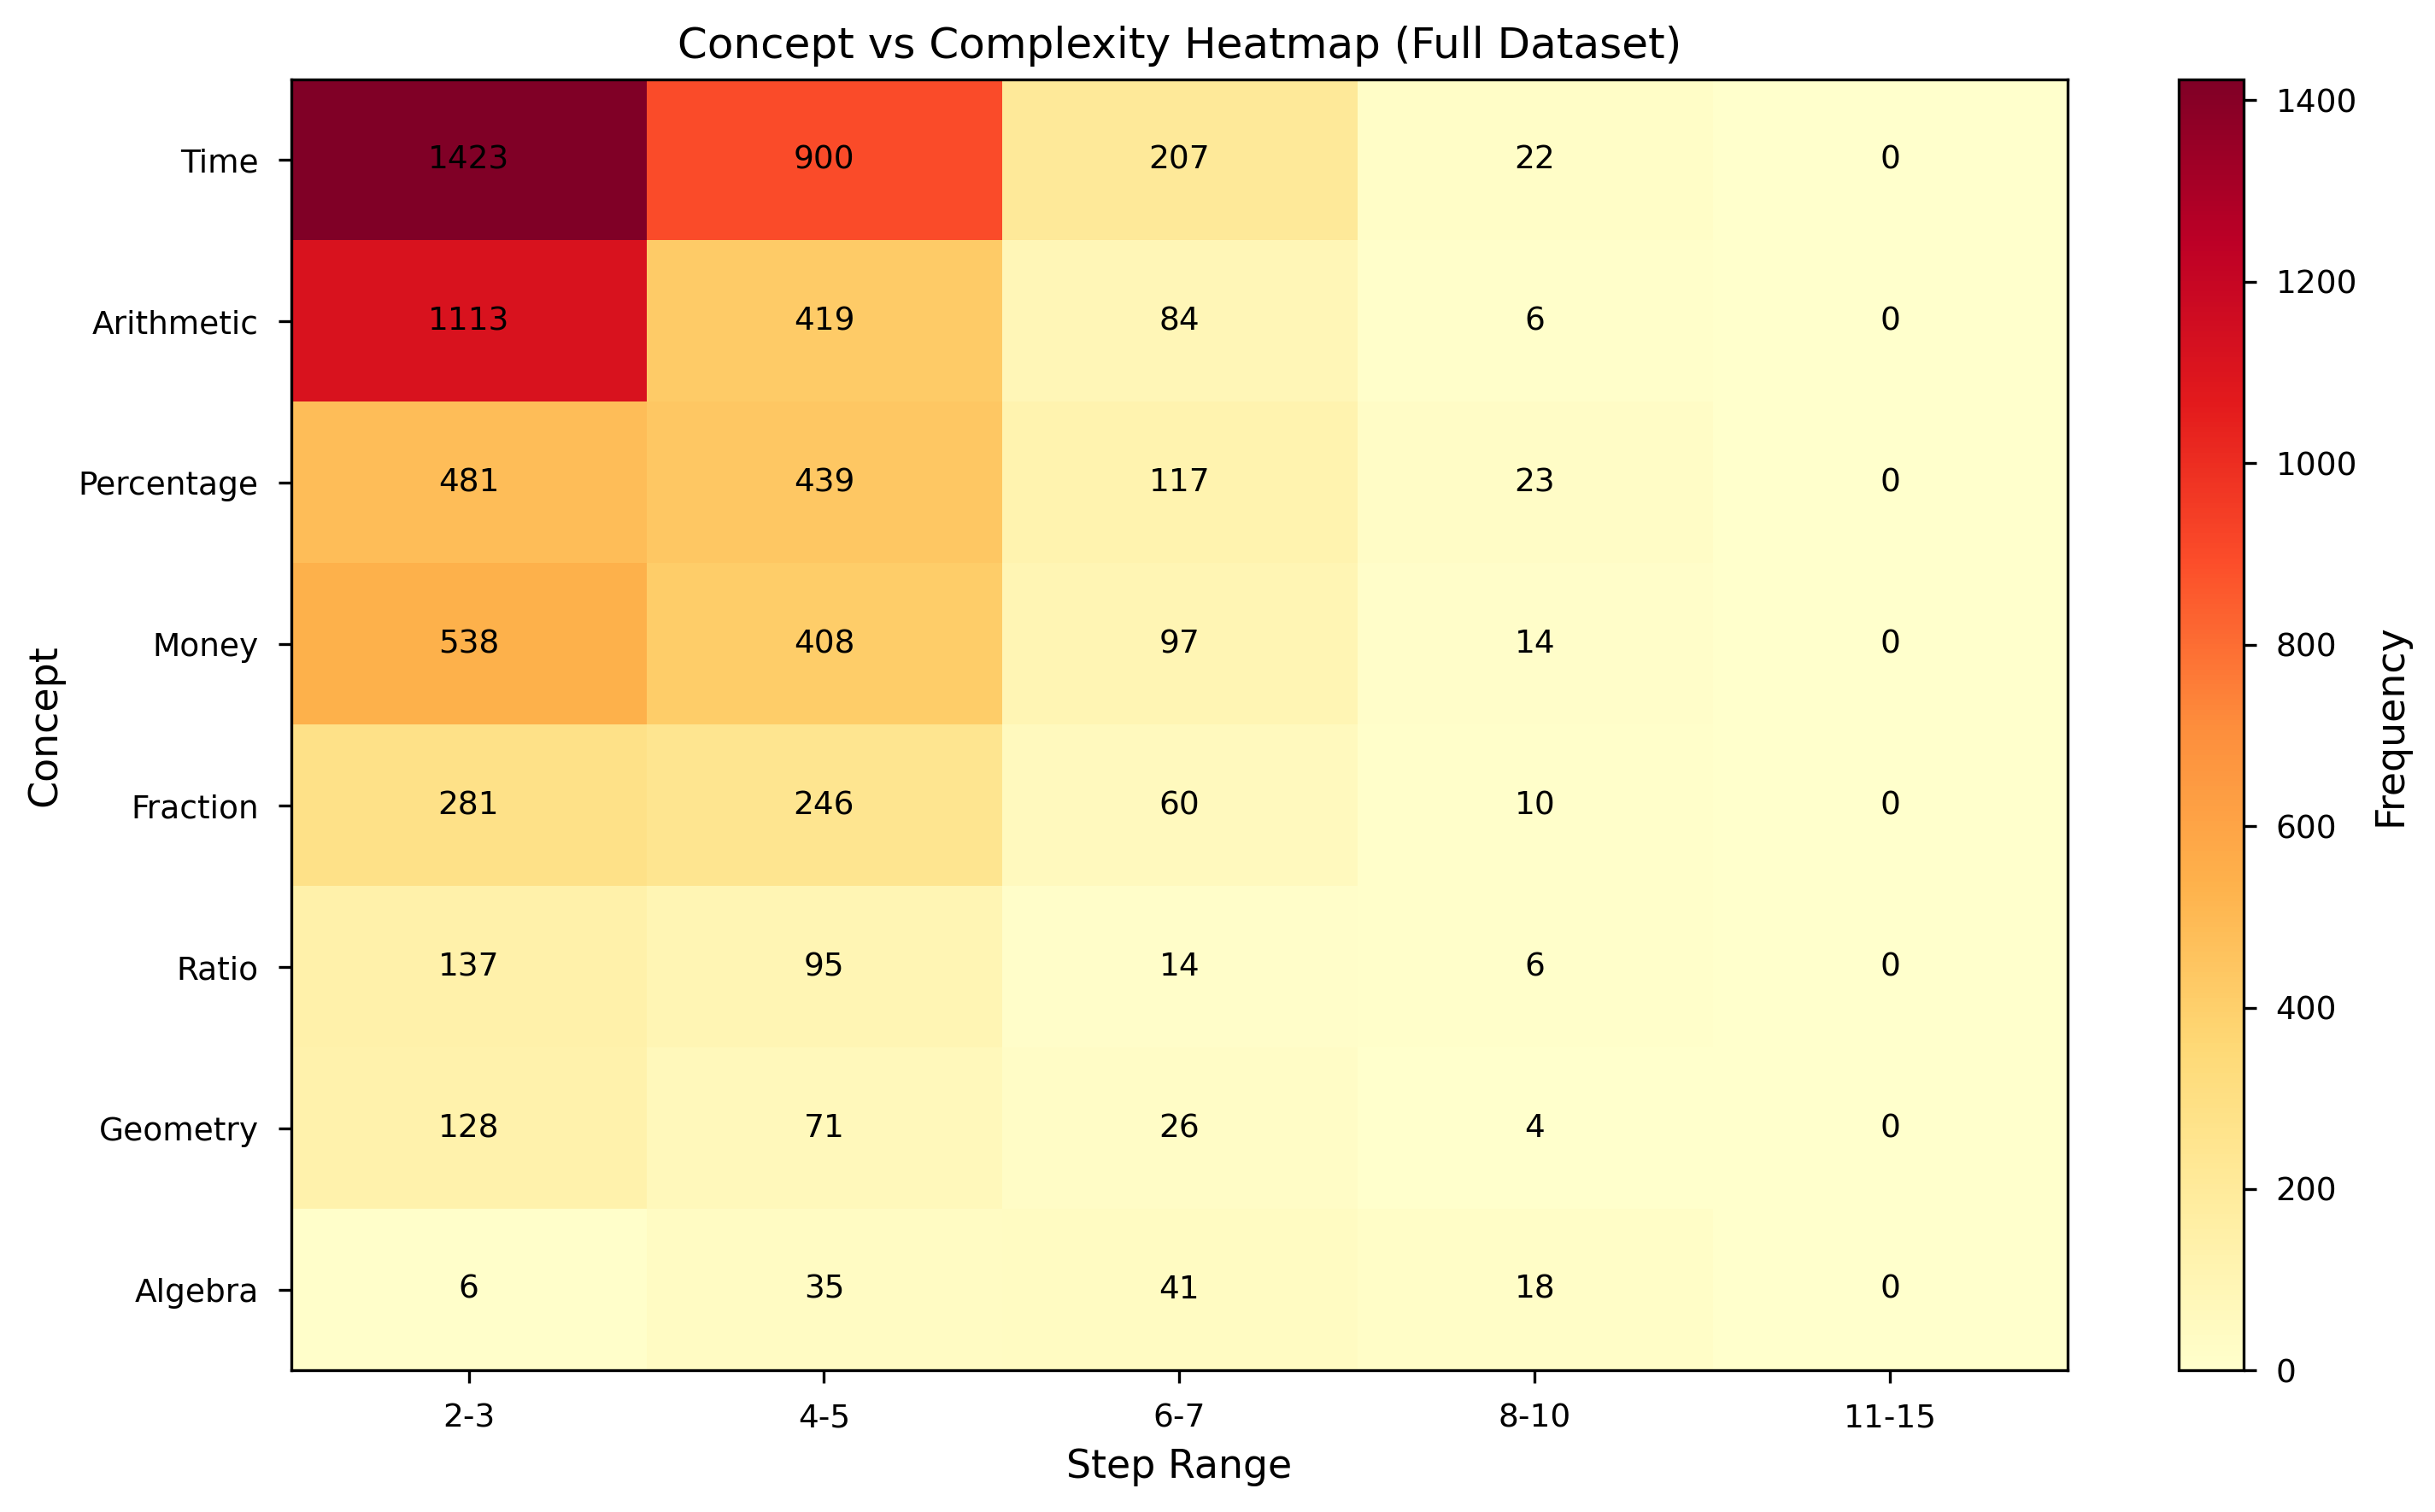

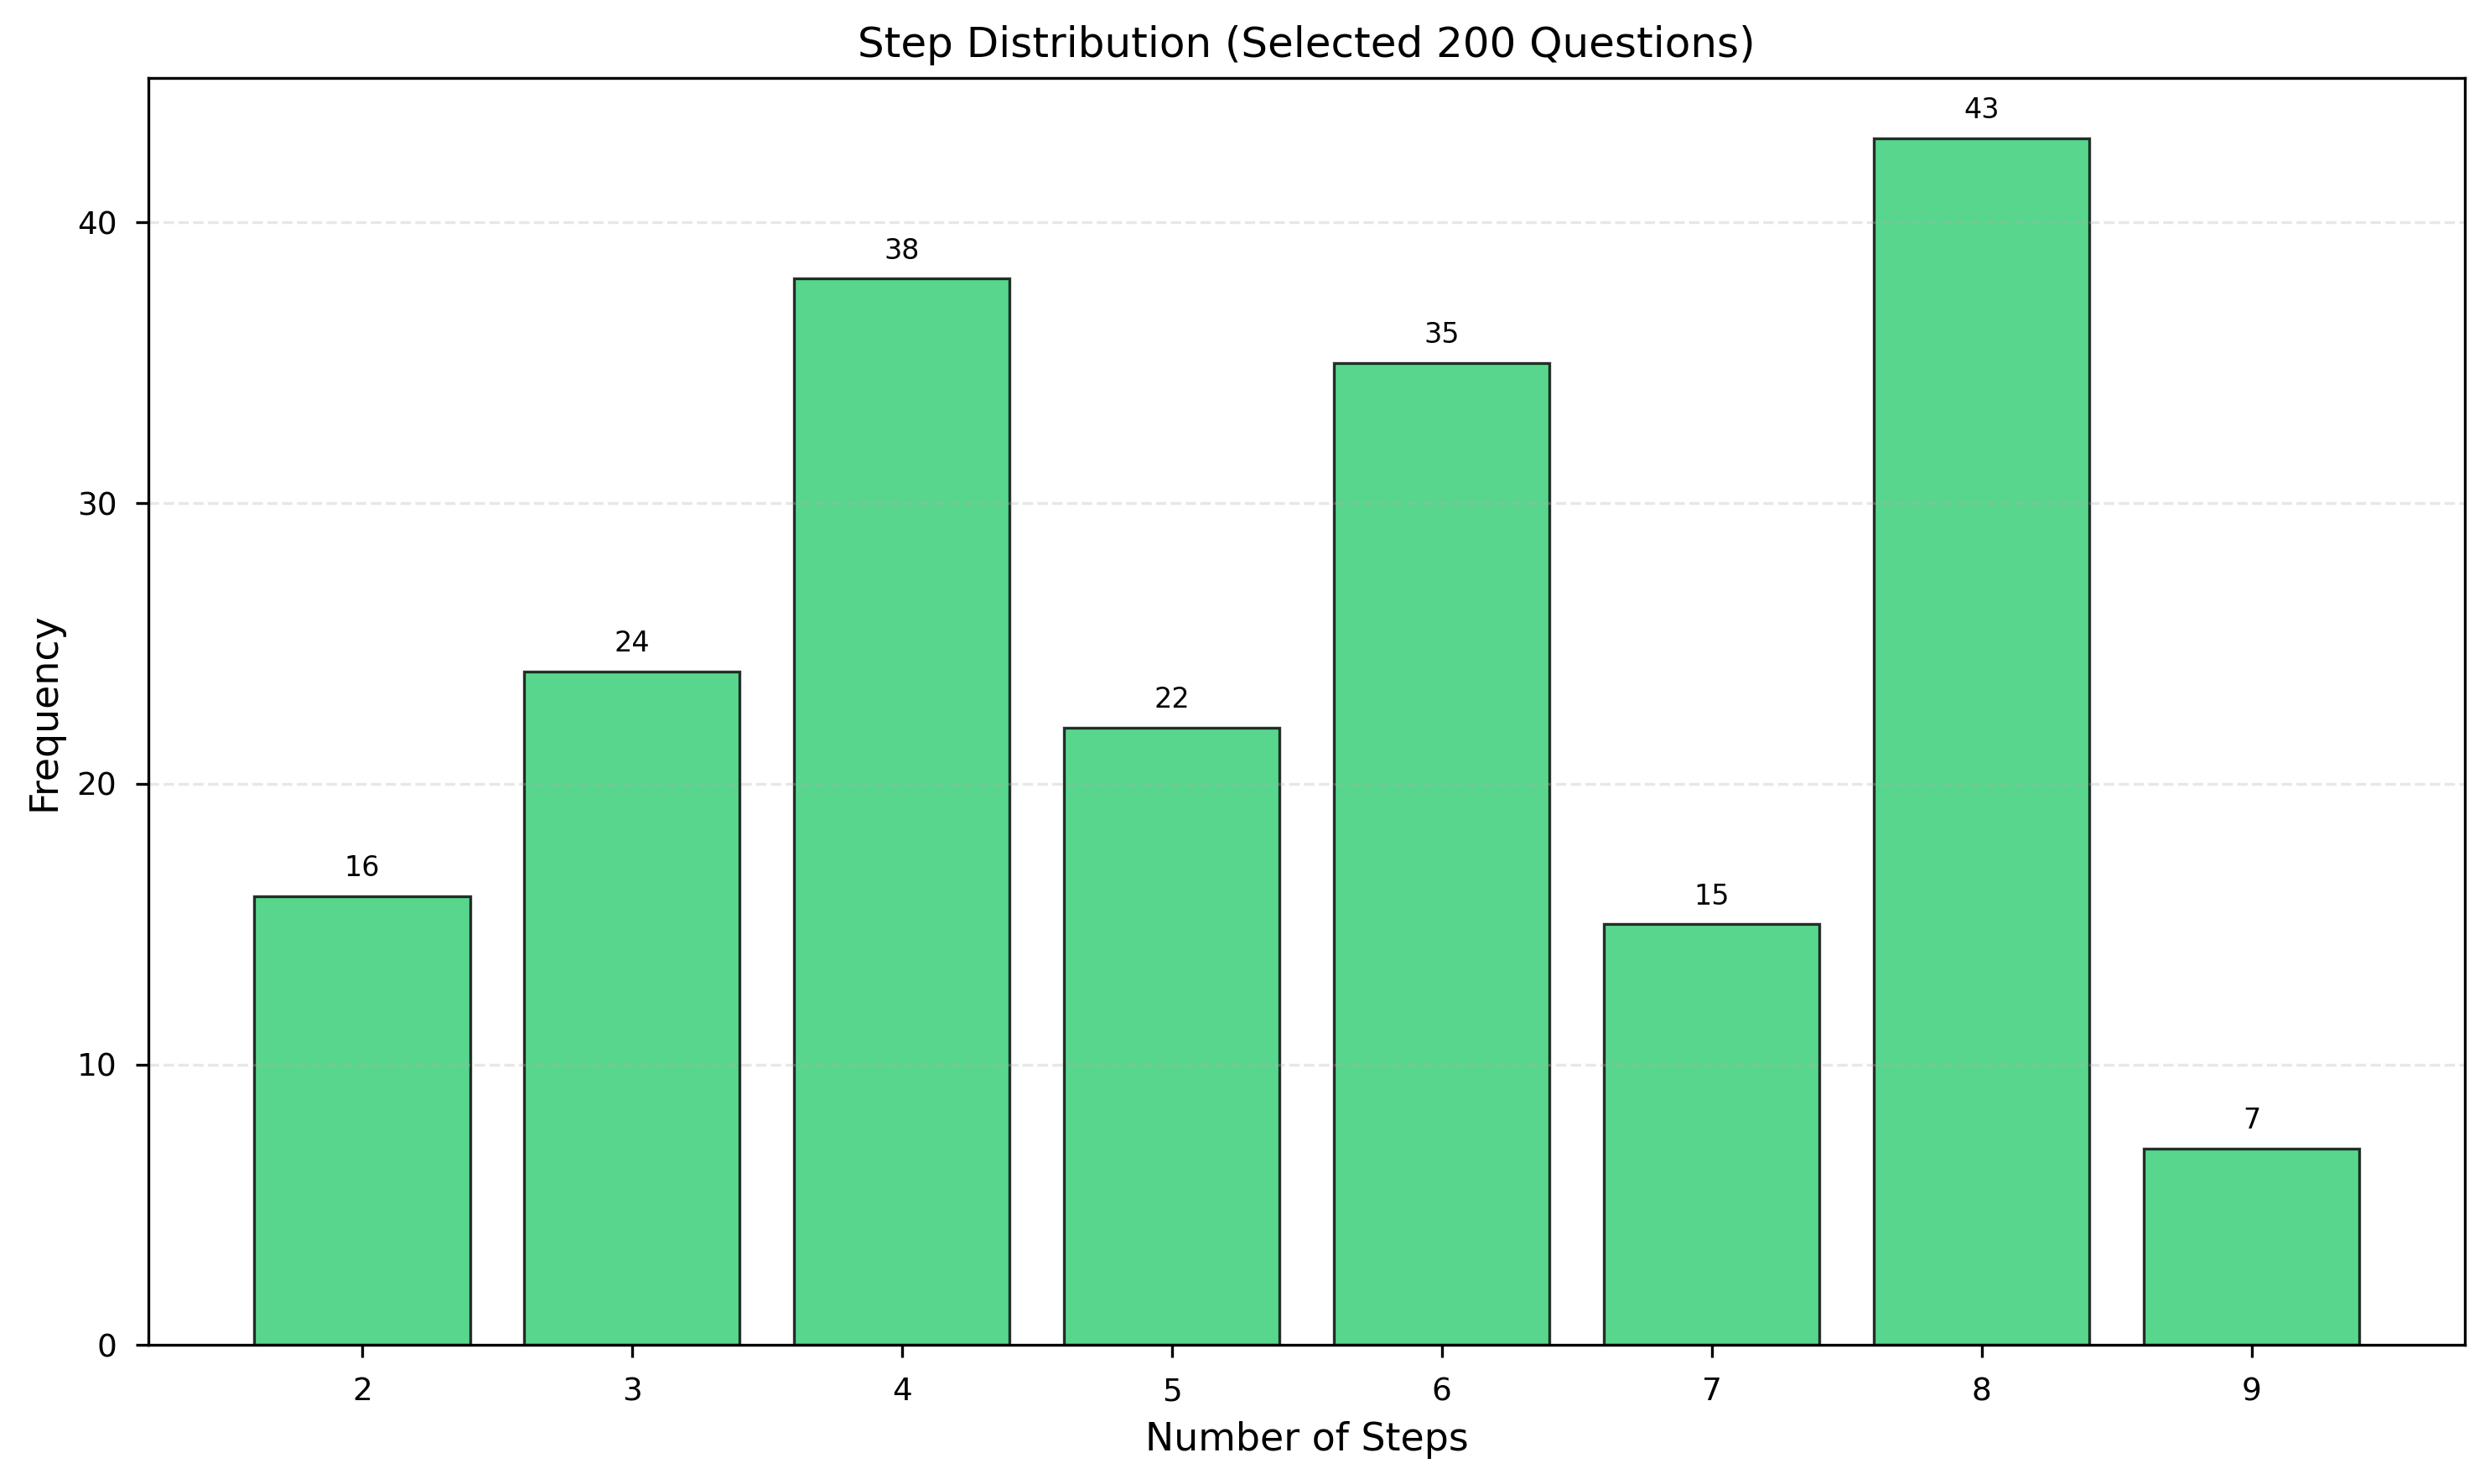

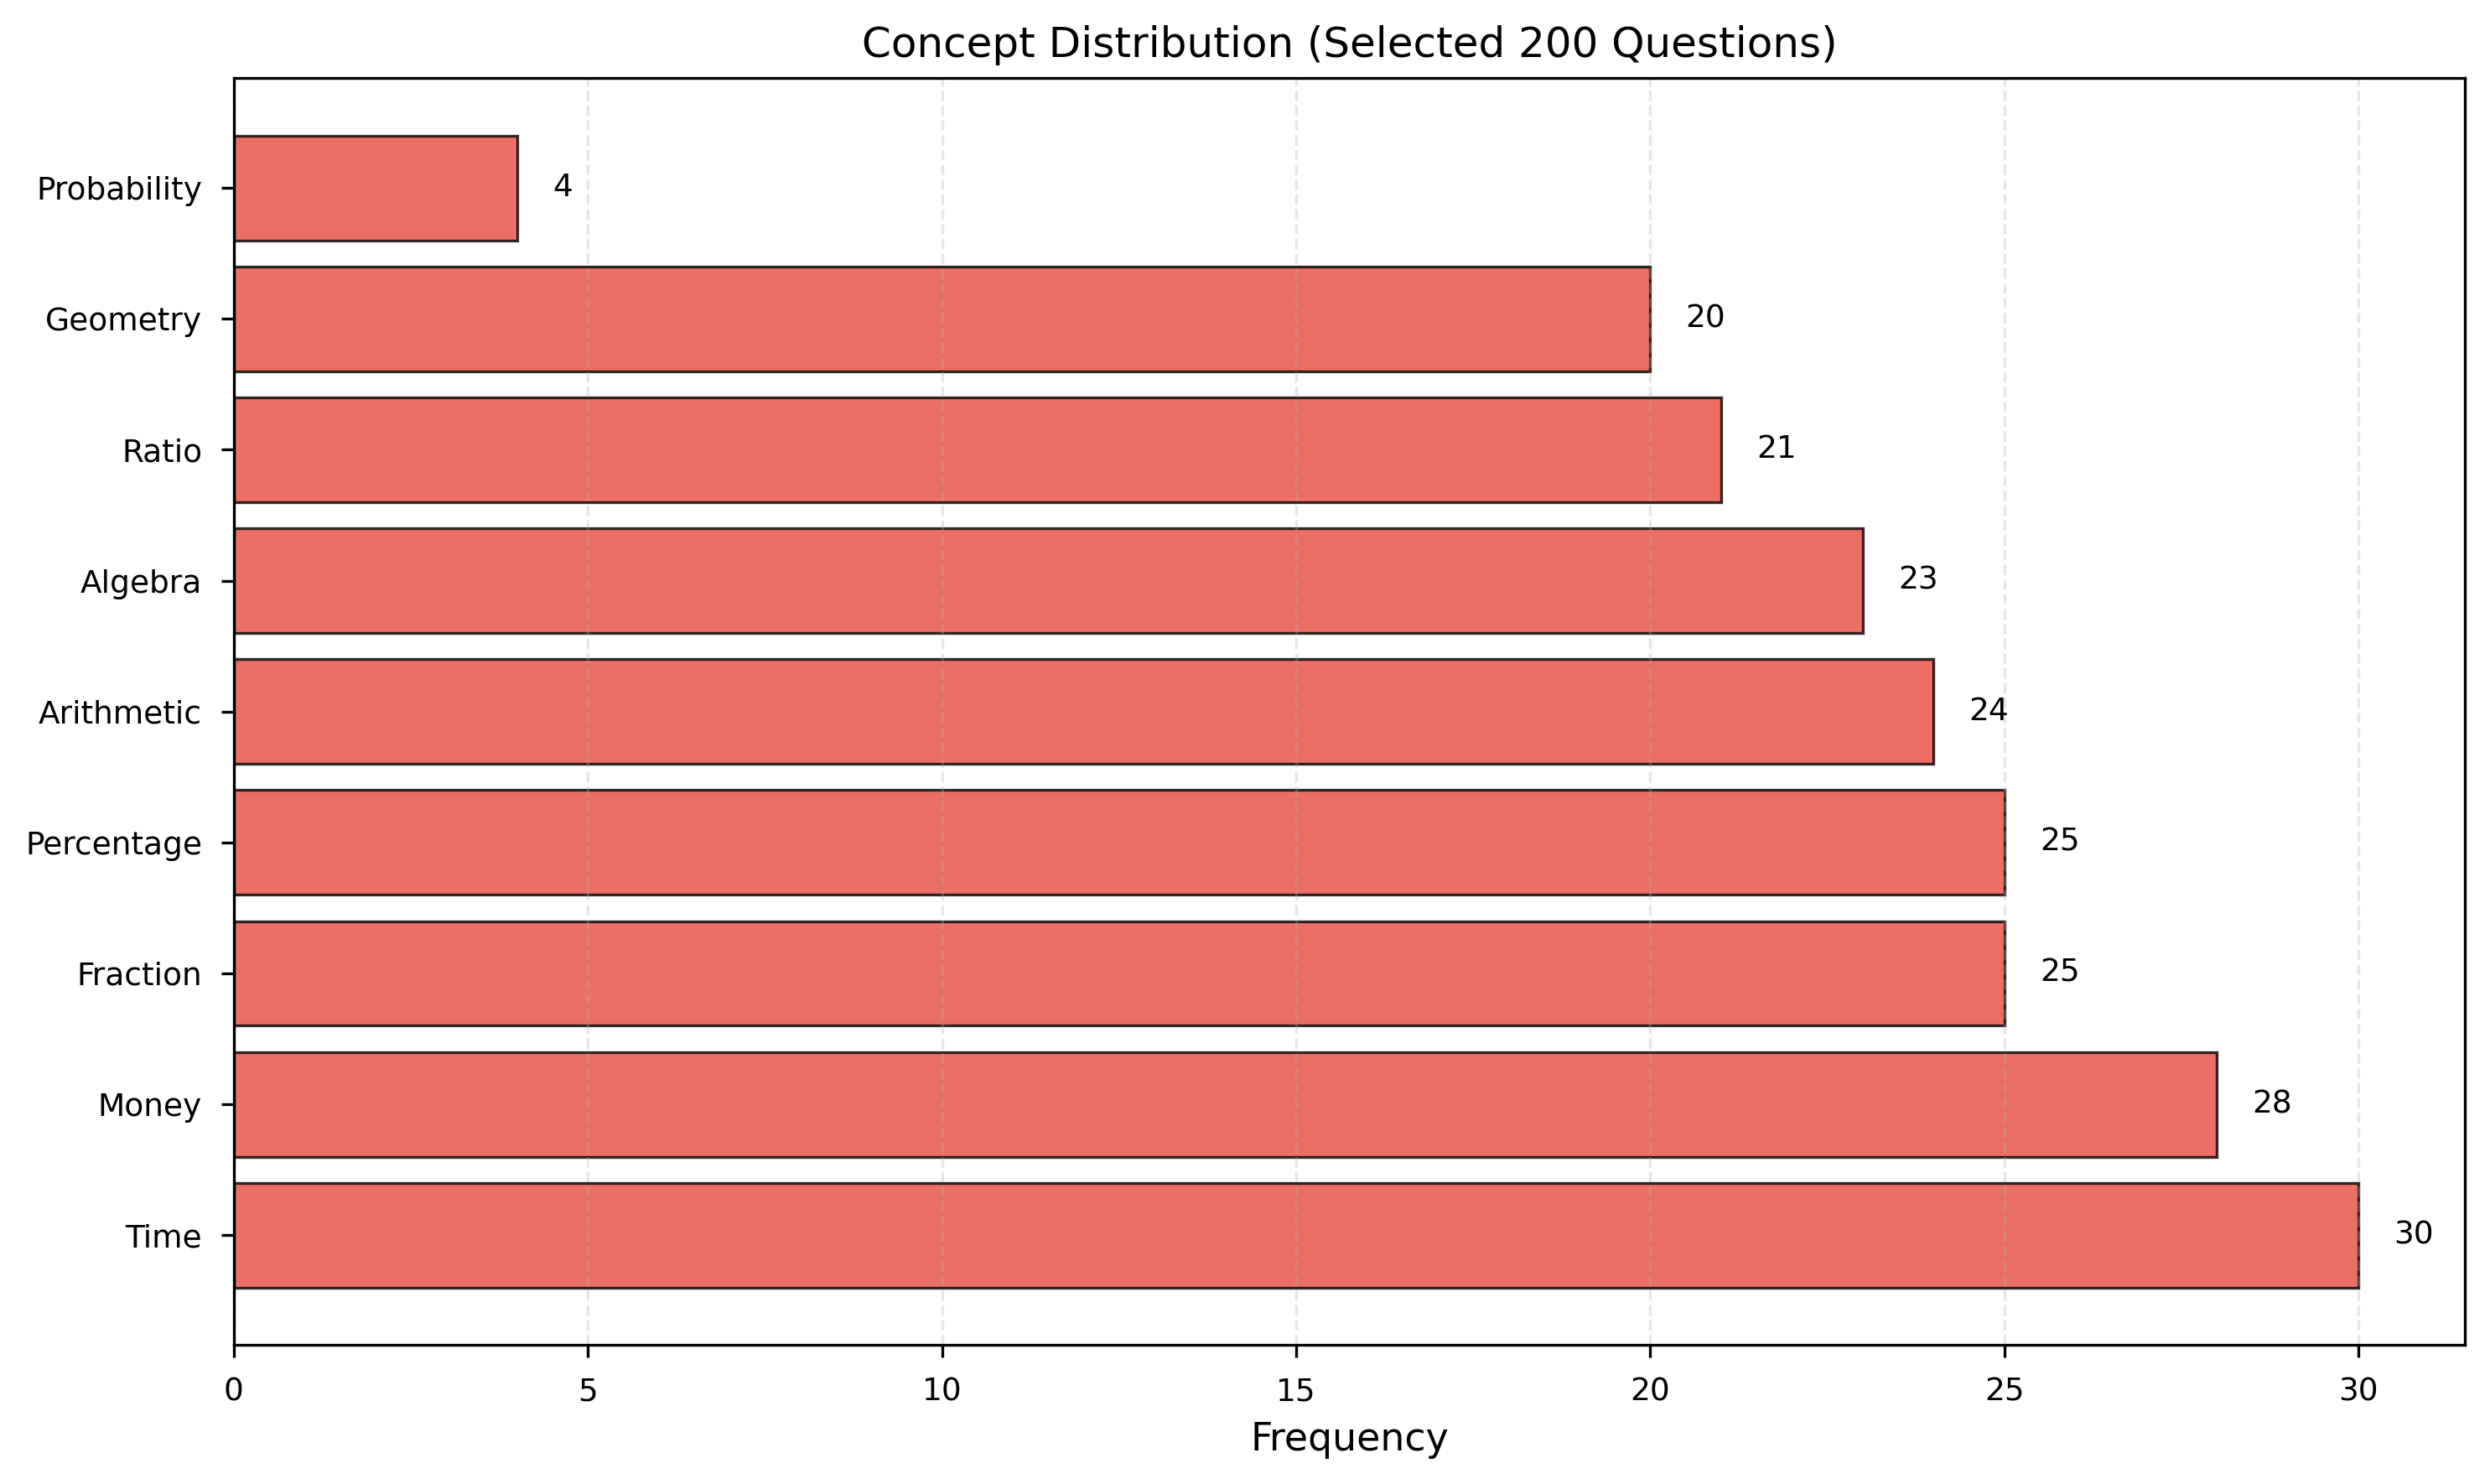

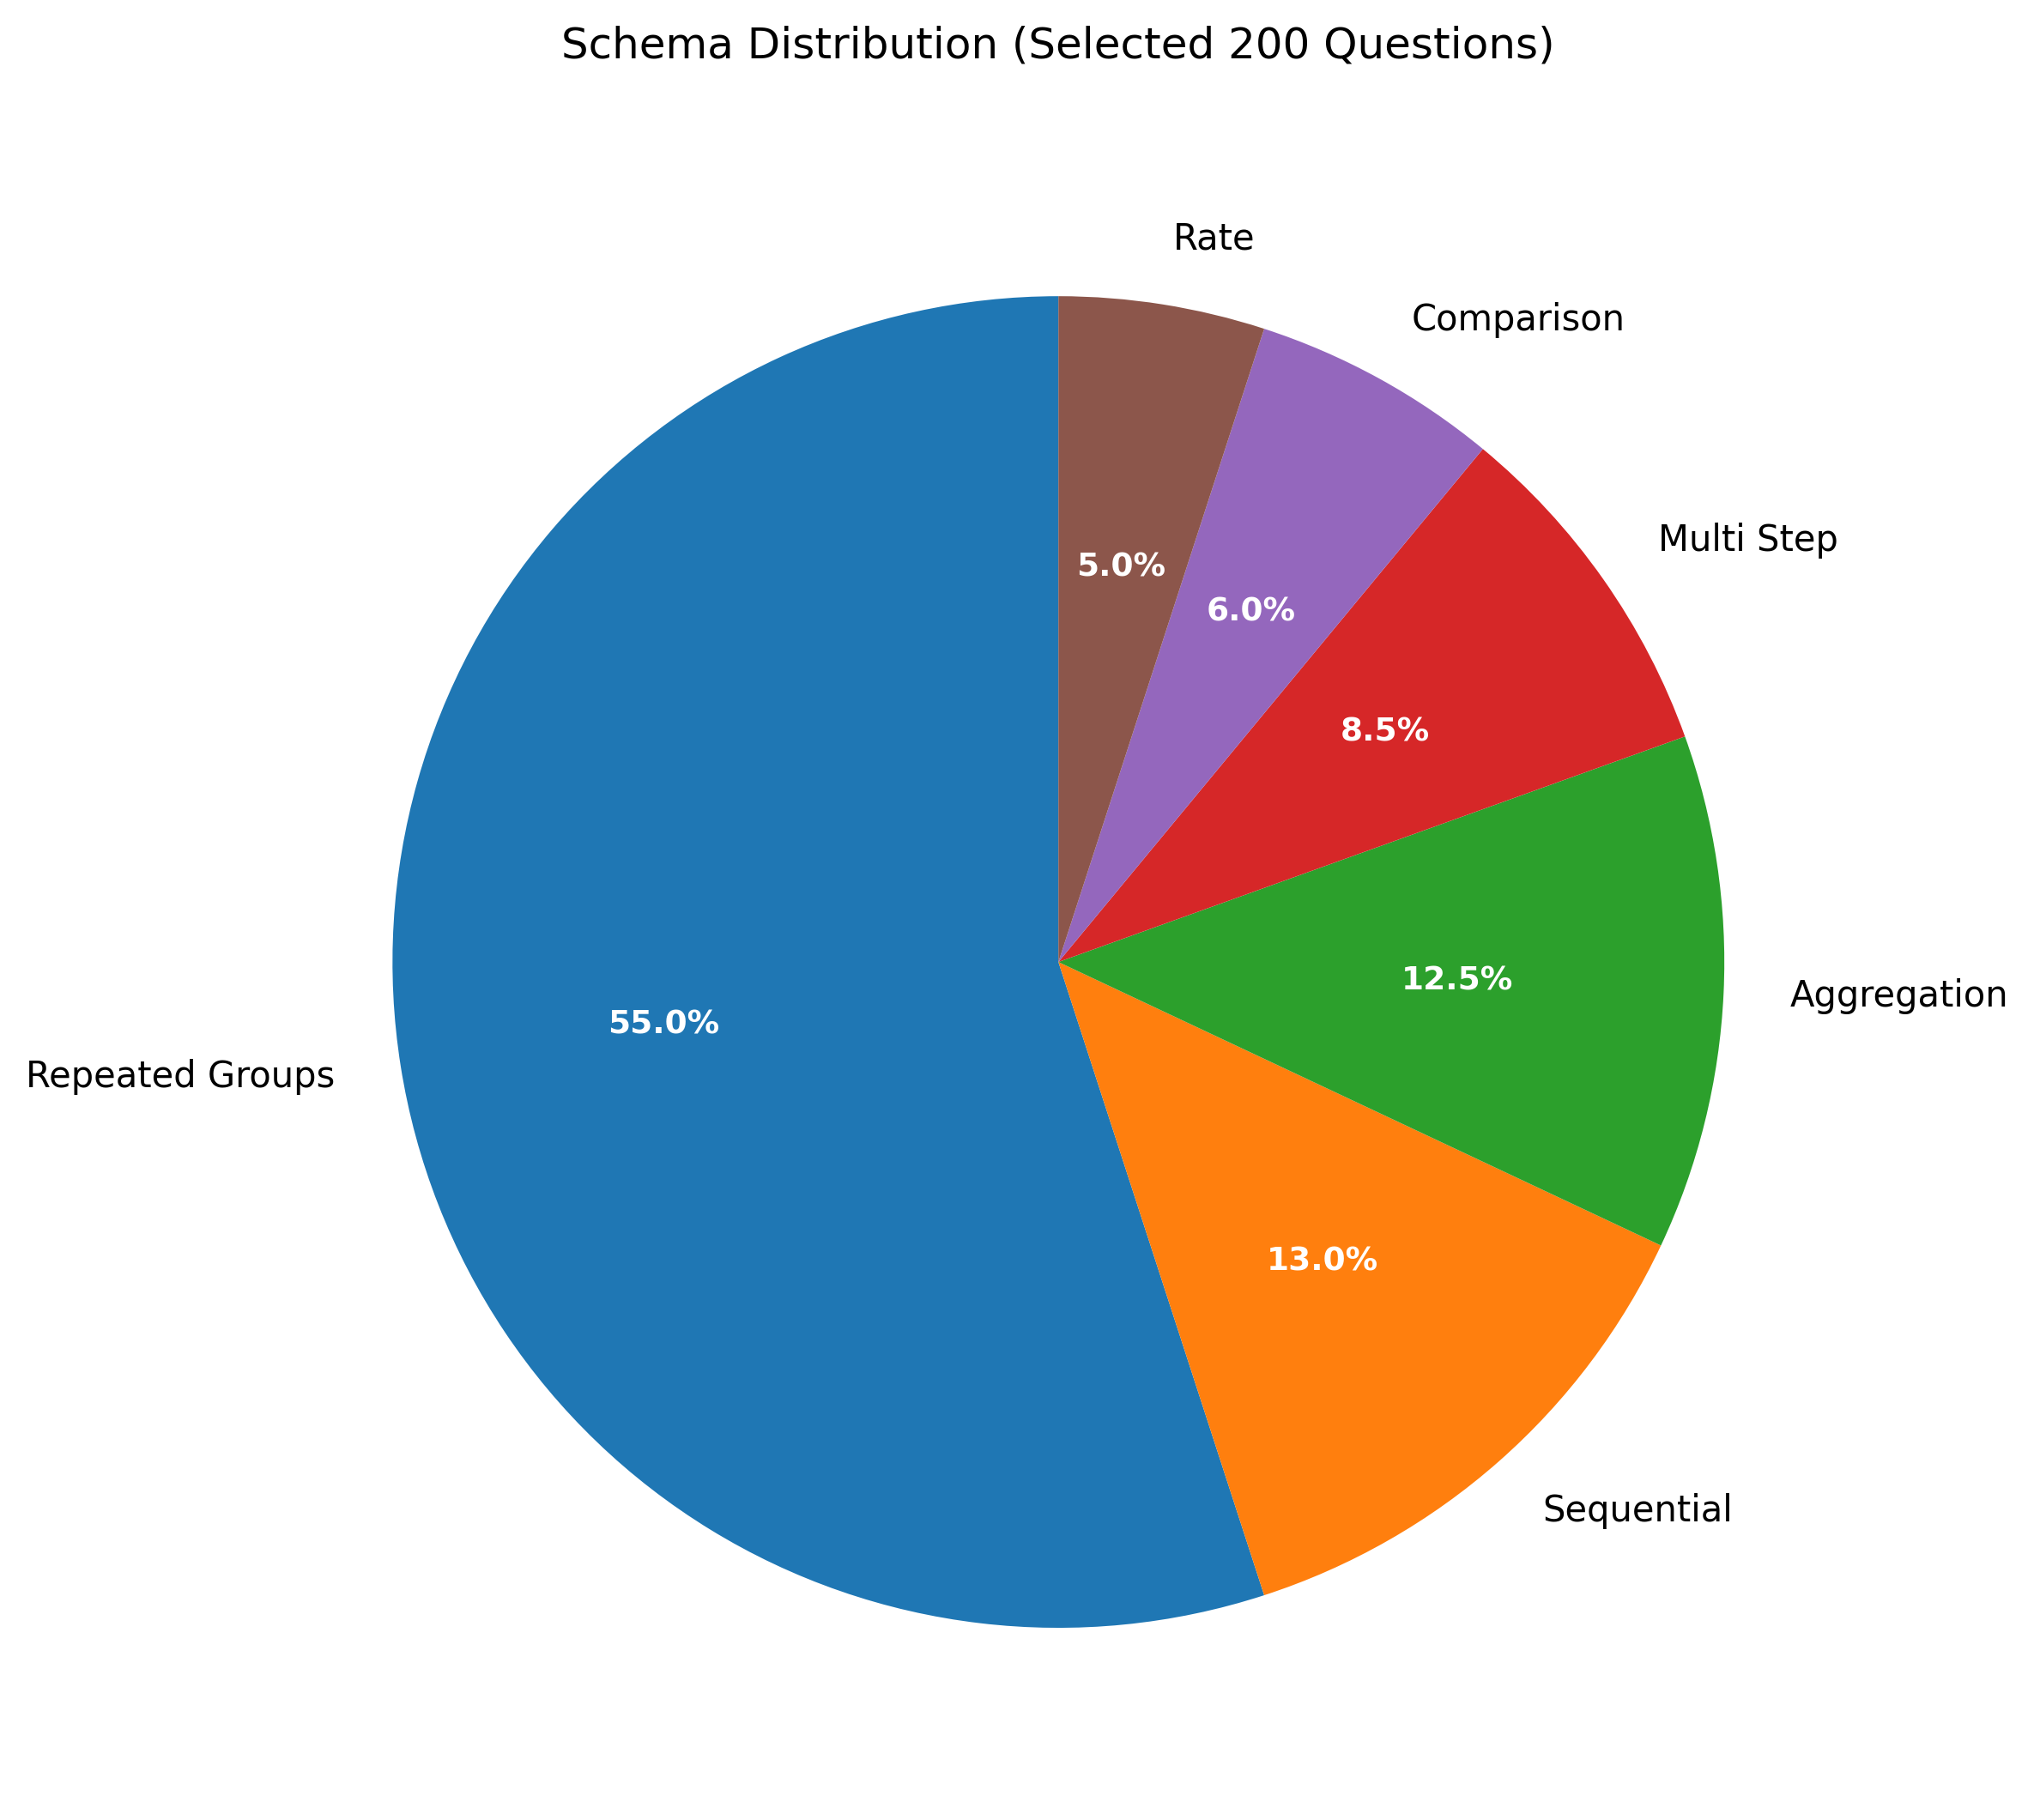

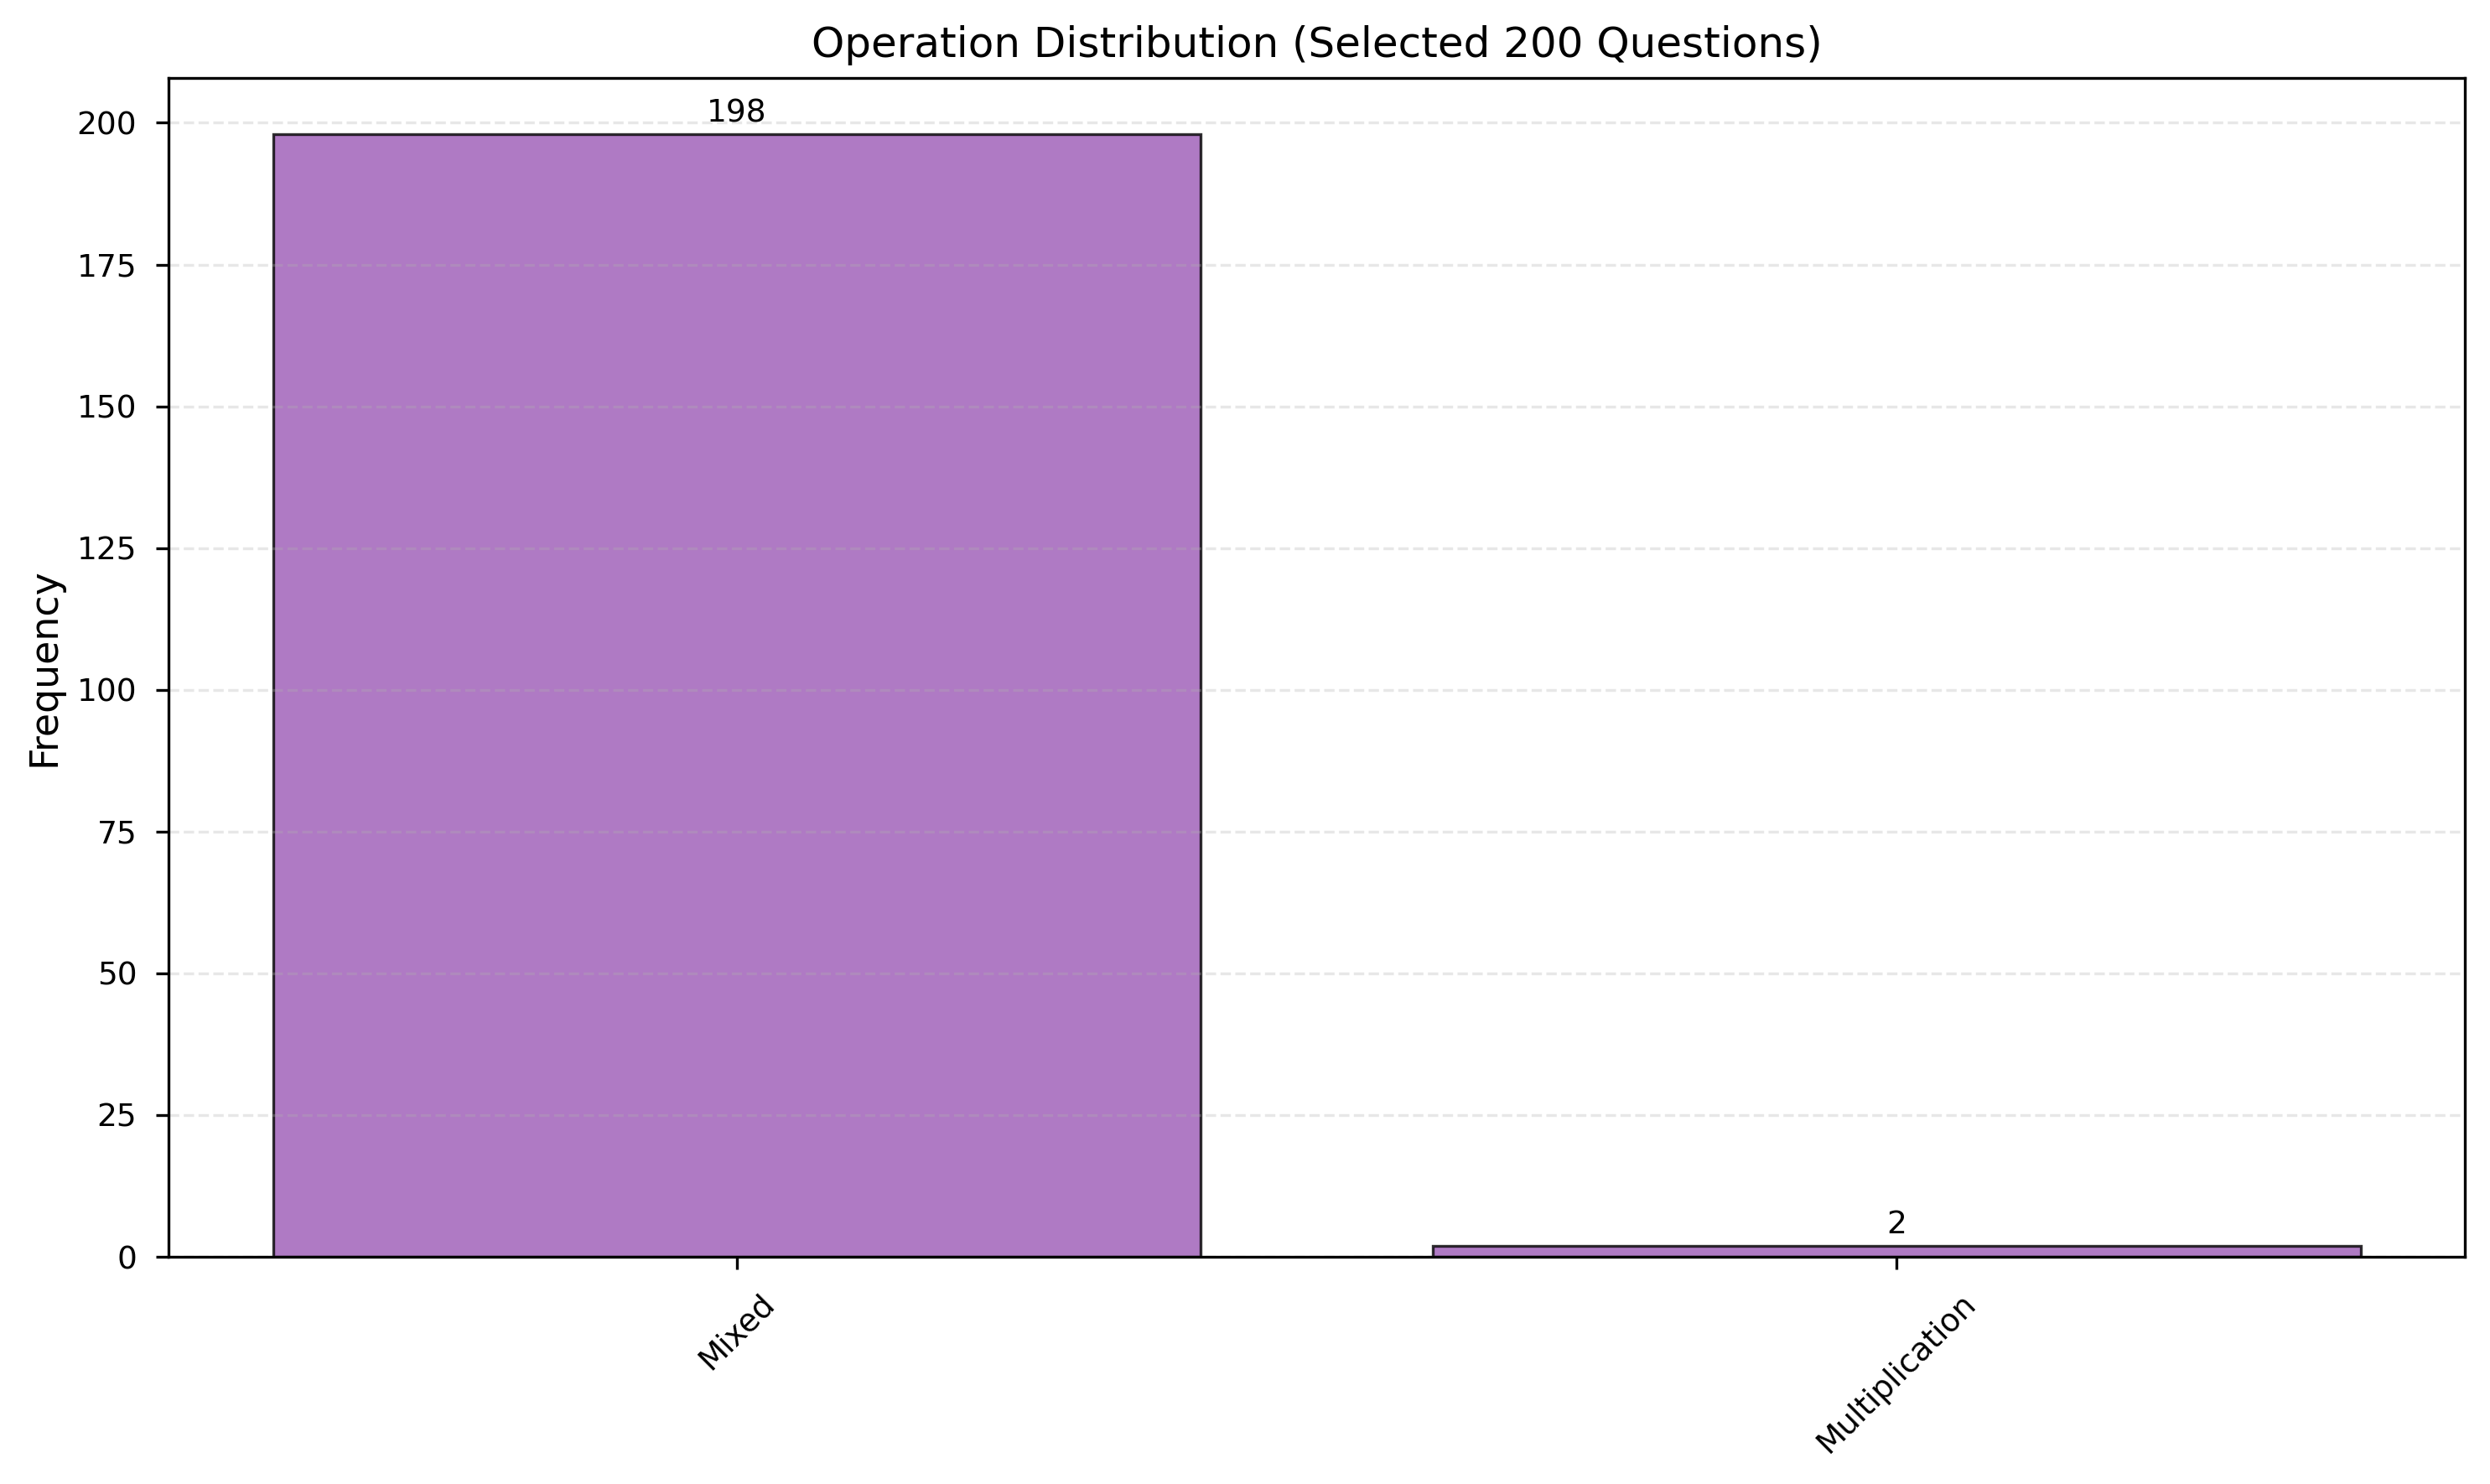

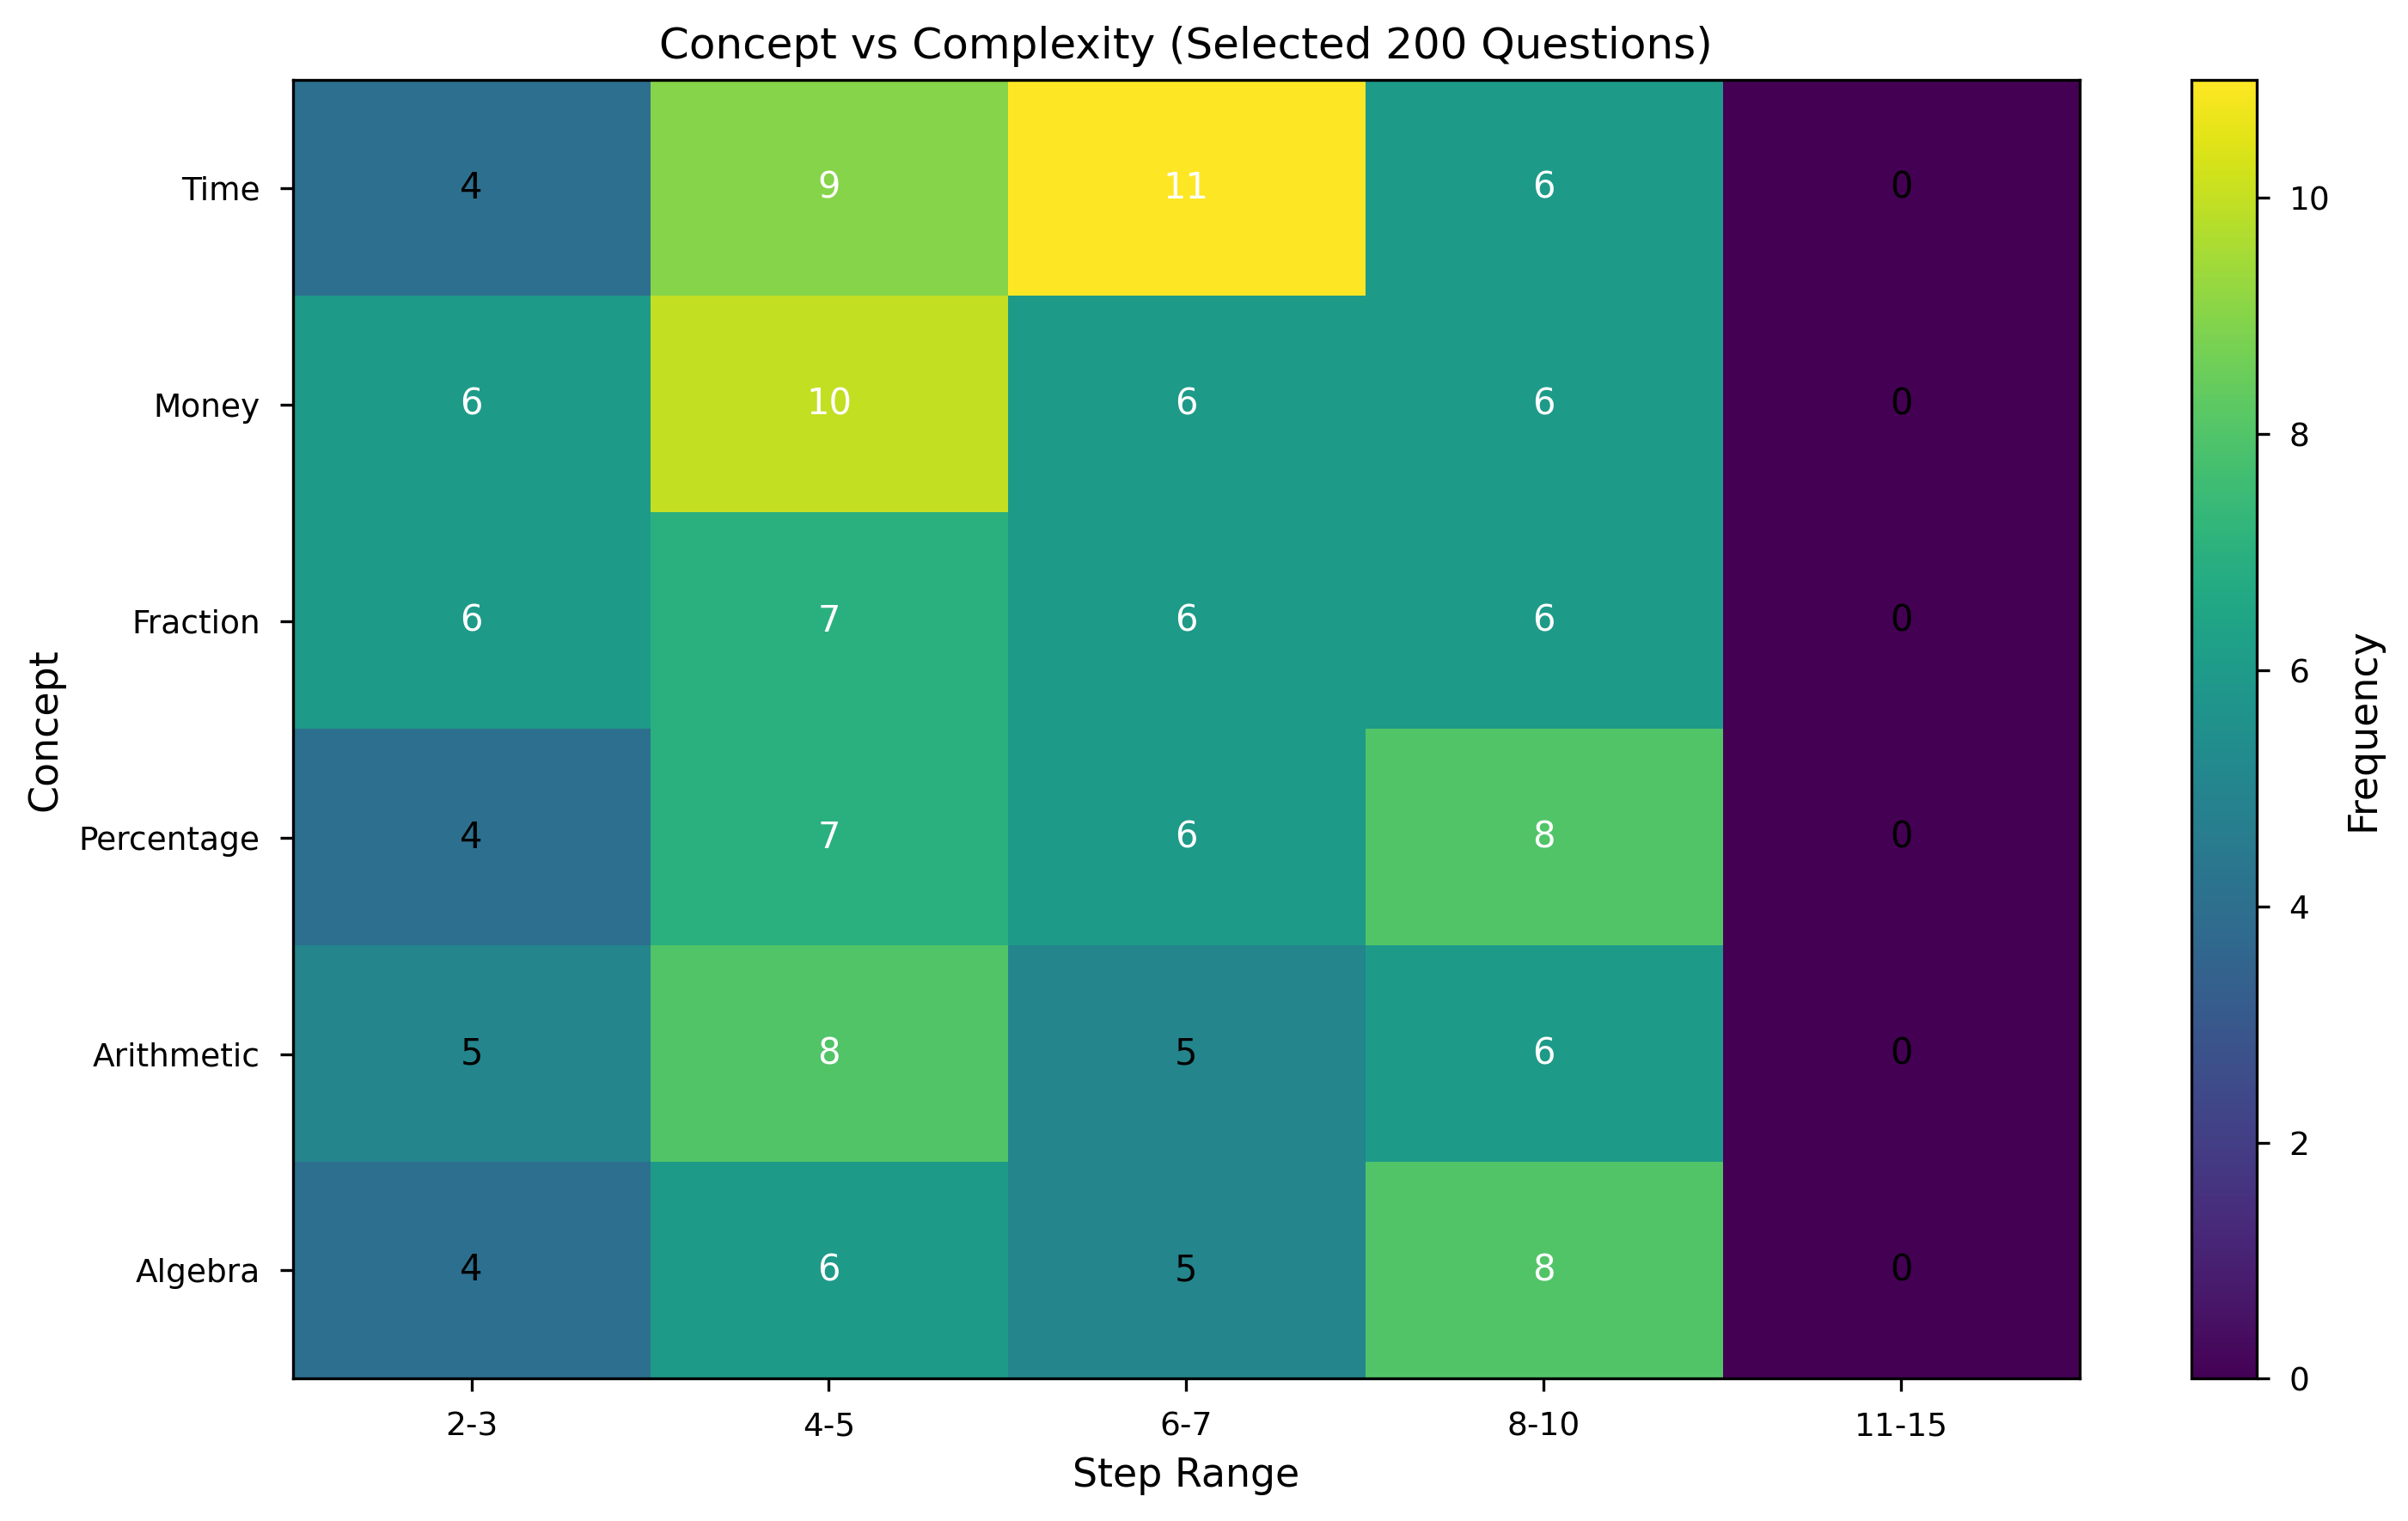

In [ ]:
import re
import random
import json
import hashlib
from collections import defaultdict
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Set style for IEEE publication quality
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

print("Loading GSM8K dataset...")
dataset = load_dataset("gsm8k", "socratic", split="train")
print(f"Total samples: {len(dataset)}\n")

# ============================================================================
# ANNOTATION FUNCTIONS
# ============================================================================

def generate_question_id(question: str, answer: str) -> str:
    """Generate unique hash-based ID for a question"""
    content = f"{question}||{answer}"
    hash_obj = hashlib.sha256(content.encode('utf-8'))
    return hash_obj.hexdigest()[:16]  # First 16 chars for readability

def extract_numerical_answer(answer: str) -> str:
    """Extract the final numerical answer from the solution"""
    match = re.search(r'####\s*(-?\d+\.?\d*)', answer)
    if match:
        return match.group(1)
    return None

def count_steps(answer: str) -> int:
    """Count solution steps (lines before ####)"""
    lines = [l.strip() for l in answer.split('\n') if l.strip()]
    return len([l for l in lines if not l.startswith('####')])

def detect_math_concept(text: str) -> str:
    """Detect primary mathematical concept"""
    t = text.lower()
    
    concepts = {
        "percentage": ["percent", "%", "discount", "interest"],
        "ratio": ["ratio", "proportion", "for every"],
        "geometry": ["area", "perimeter", "length", "width", "height", "volume"],
        "time": ["hour", "minute", "day", "week", "month", "year"],
        "money": ["dollar", "cost", "price", "pay", "earn", "spent", "$"],
        "fraction": ["half", "third", "quarter", "fraction"],
        "probability": ["chance", "probability", "likely"],
        "algebra": ["equation", "unknown", "variable", "solve for"]
    }
    
    found = []
    for concept, keywords in concepts.items():
        if any(k in t for k in keywords):
            found.append(concept)
    
    return found[0] if found else "arithmetic"

def detect_operation(text: str) -> str:
    """Detect primary operations used"""
    text = text.lower()
    
    ops = {
        "multiplication": ["times", "×", "*", "each", "per"],
        "division": ["divide", "÷", "/", "split", "shared equally", "average"],
        "addition": ["total", "sum", "+", "together", "in all", "combined"],
        "subtraction": ["left", "remaining", "-", "less", "difference", "more than"]
    }
    
    found = []
    for op, keywords in ops.items():
        if any(k in text for k in keywords):
            found.append(op)
    
    if len(found) == 0:
        return "unknown"
    if len(found) == 1:
        return found[0]
    return "mixed"

def detect_schema(question: str) -> str:
    """Detect problem structure/schema"""
    q = question.lower()
    
    if any(k in q for k in ["each", "every", "per"]):
        return "repeated_groups"
    
    if any(k in q for k in ["total", "sum", "altogether"]):
        return "aggregation"
    
    if any(k in q for k in ["more than", "less than", "difference", "how many more"]):
        return "comparison"
    
    if any(k in q for k in ["cost", "price", "per", "rate"]):
        return "rate"
    
    if any(k in q for k in ["if", "then", "first", "second"]):
        return "sequential"
    
    return "multi_step"

def has_large_numbers(text: str) -> bool:
    """Check if contains numbers > 1000"""
    numbers = re.findall(r'\d+', text)
    return any(int(n) > 1000 for n in numbers if n)

def has_decimals(text: str) -> bool:
    """Check if contains decimal numbers"""
    return bool(re.search(r'\d+\.\d+', text))

# ============================================================================
# ANNOTATE DATASET
# ============================================================================

print("Annotating dataset...")
annotated = []

for i, ex in enumerate(dataset):
    question = ex["question"]
    answer = ex["answer"]
    question_id = generate_question_id(question, answer)
    
    annotated.append({
        "original_id": i,
        "question_id": question_id,
        "question": question,
        "answer": answer,
        "numerical_answer": extract_numerical_answer(answer),
        "steps": count_steps(answer),
        "concept": detect_math_concept(question + " " + answer),
        "operation": detect_operation(answer),
        "schema": detect_schema(question),
        "has_large_numbers": has_large_numbers(question),
        "has_decimals": has_decimals(answer)
    })

print(f"Annotation complete: {len(annotated)} questions\n")

# ============================================================================
# ANALYSIS OF FULL DATASET
# ============================================================================

print("=== FULL DATASET ANALYSIS ===\n")

step_counts = defaultdict(int)
concept_counts = defaultdict(int)
schema_counts = defaultdict(int)
operation_counts = defaultdict(int)

for ex in annotated:
    step_counts[ex["steps"]] += 1
    concept_counts[ex["concept"]] += 1
    schema_counts[ex["schema"]] += 1
    operation_counts[ex["operation"]] += 1

print("Step distribution:")
for steps in sorted(step_counts.keys())[:15]:
    print(f"  {steps} steps: {step_counts[steps]}")

print("\nConcept distribution:")
for concept, count in sorted(concept_counts.items(), key=lambda x: -x[1]):
    print(f"  {concept}: {count}")

print("\nSchema distribution:")
for schema, count in sorted(schema_counts.items(), key=lambda x: -x[1]):
    print(f"  {schema}: {count}")

# Create visualization directory
vis_dir = Path("visualizations")
vis_dir.mkdir(exist_ok=True)

# ============================================================================
# VISUALIZATION 1: Full Dataset Overview
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# Step Distribution
ax1 = axes[0, 0]
steps_data = sorted([(k, v) for k, v in step_counts.items() if k <= 15], key=lambda x: x[0])
steps_x = [x[0] for x in steps_data]
steps_y = [x[1] for x in steps_data]
ax1.bar(steps_x, steps_y, color='steelblue', alpha=0.8, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Number of Steps')
ax1.set_ylabel('Frequency')
ax1.set_title('Step Distribution (Full Dataset)')
ax1.grid(axis='y', alpha=0.3)

# Concept Distribution
ax2 = axes[0, 1]
concepts = sorted(concept_counts.items(), key=lambda x: -x[1])[:8]
concept_names = [c[0].replace('_', ' ').title() for c in concepts]
concept_vals = [c[1] for c in concepts]
ax2.barh(concept_names, concept_vals, color='coral', alpha=0.8, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Frequency')
ax2.set_title('Top Concepts (Full Dataset)')
ax2.grid(axis='x', alpha=0.3)

# Schema Distribution
ax3 = axes[1, 0]
schemas = sorted(schema_counts.items(), key=lambda x: -x[1])
schema_names = [s[0].replace('_', ' ').title() for s in schemas]
schema_vals = [s[1] for s in schemas]
colors = plt.cm.Set3(range(len(schemas)))
ax3.pie(schema_vals, labels=schema_names, autopct='%1.1f%%', startangle=90, colors=colors)
ax3.set_title('Schema Distribution (Full Dataset)')

# Operation Type
ax4 = axes[1, 1]
operations = sorted(operation_counts.items(), key=lambda x: -x[1])
op_names = [o[0].replace('_', ' ').title() for o in operations]
op_vals = [o[1] for o in operations]
ax4.bar(op_names, op_vals, color='lightgreen', alpha=0.8, edgecolor='black', linewidth=0.5)
ax4.set_ylabel('Frequency')
ax4.set_title('Operation Types (Full Dataset)')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(vis_dir / 'full_dataset_overview.png', bbox_inches='tight', dpi=300)
print(f"✓ Saved: visualizations/full_dataset_overview.png")

# ============================================================================
# VISUALIZATION 2: Concept vs Complexity Heatmap (Full Dataset)
# ============================================================================

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
top_concepts = [c[0] for c in sorted(concept_counts.items(), key=lambda x: -x[1])[:8]]
step_bins = [(2,3), (4,5), (6,7), (8,10), (11,15)]
heatmap_data = []

for concept in top_concepts:
    row = []
    for step_min, step_max in step_bins:
        count = sum(1 for ex in annotated 
                   if ex['concept'] == concept and step_min <= ex['steps'] <= step_max)
        row.append(count)
    heatmap_data.append(row)

heatmap_data = np.array(heatmap_data)
im = ax.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
ax.set_xticks(range(len(step_bins)))
ax.set_xticklabels([f'{s[0]}-{s[1]}' for s in step_bins])
ax.set_yticks(range(len(top_concepts)))
ax.set_yticklabels([c.replace('_', ' ').title() for c in top_concepts])
ax.set_xlabel('Step Range')
ax.set_ylabel('Concept')
ax.set_title('Concept vs Complexity Heatmap (Full Dataset)')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Frequency')

for i in range(len(top_concepts)):
    for j in range(len(step_bins)):
        ax.text(j, i, heatmap_data[i, j], ha="center", va="center", color="black", fontsize=9)

plt.tight_layout()
plt.savefig(vis_dir / 'full_dataset_heatmap.png', bbox_inches='tight', dpi=300)
print(f"✓ Saved: visualizations/full_dataset_heatmap.png")

# ============================================================================
# STRATIFIED DIVERSE SAMPLING
# ============================================================================

def stratified_diverse_sample(data, n=200, seed=42):
    """Stratified sampling for maximum diversity"""
    random.seed(seed)
    
    target_dist = {
        "steps": {
            "2-3": 40,
            "4-5": 60,
            "6-7": 50,
            "8+": 50
        }
    }
    
    by_steps = defaultdict(list)
    for ex in data:
        steps = ex["steps"]
        if steps <= 3:
            key = "2-3"
        elif steps <= 5:
            key = "4-5"
        elif steps <= 7:
            key = "6-7"
        else:
            key = "8+"
        by_steps[key].append(ex)
    
    sampled = []
    used_ids = set()
    
    for step_key, target_count in target_dist["steps"].items():
        candidates = by_steps[step_key]
        by_concept = defaultdict(list)
        for ex in candidates:
            by_concept[ex["concept"]].append(ex)
        
        group_samples = []
        concepts = list(by_concept.keys())
        random.shuffle(concepts)
        samples_per_concept = max(1, target_count // len(concepts))
        
        for concept in concepts:
            available = [ex for ex in by_concept[concept] if ex["question_id"] not in used_ids]
            take = min(samples_per_concept, len(available))
            if take > 0:
                selected = random.sample(available, take)
                group_samples.extend(selected)
                used_ids.update(ex["question_id"] for ex in selected)
        
        if len(group_samples) < target_count:
            available = [ex for ex in candidates if ex["question_id"] not in used_ids]
            needed = target_count - len(group_samples)
            if available:
                extra = random.sample(available, min(needed, len(available)))
                group_samples.extend(extra)
                used_ids.update(ex["question_id"] for ex in extra)
        
        sampled.extend(group_samples[:target_count])
    
    random.shuffle(sampled)
    return sampled[:n]

print("\n=== SELECTING 200 DIVERSE QUESTIONS ===\n")
selected_200 = stratified_diverse_sample(annotated, n=200, seed=42)
print(f"Selected: {len(selected_200)} questions")

# Analyze selection
sel_steps = defaultdict(int)
sel_concepts = defaultdict(int)
sel_schemas = defaultdict(int)
sel_operations = defaultdict(int)

for ex in selected_200:
    sel_steps[ex["steps"]] += 1
    sel_concepts[ex["concept"]] += 1
    sel_schemas[ex["schema"]] += 1
    sel_operations[ex["operation"]] += 1

print("\nSelected distribution:")
print(f"  Steps: {dict(sorted(sel_steps.items())[:10])}")
print(f"  Concepts: {dict(sorted(sel_concepts.items(), key=lambda x: -x[1])[:5])}")
print(f"  Schemas: {dict(sorted(sel_schemas.items(), key=lambda x: -x[1]))}")

# ============================================================================
# VISUALIZATION 3: Selected 200 - Step Distribution
# ============================================================================

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
step_range = sorted(sel_steps.keys())
step_vals = [sel_steps[s] for s in step_range]

ax.bar(step_range, step_vals, color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=0.8)
ax.set_xlabel('Number of Steps')
ax.set_ylabel('Frequency')
ax.set_title('Step Distribution (Selected 200 Questions)')
ax.grid(axis='y', alpha=0.3, linestyle='--')

for i, (step, val) in enumerate(zip(step_range, step_vals)):
    ax.text(step, val + 0.5, str(val), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(vis_dir / 'selected_step_distribution.png', bbox_inches='tight', dpi=300)
print(f"\n✓ Saved: visualizations/selected_step_distribution.png")

# ============================================================================
# VISUALIZATION 4: Selected 200 - Concept Distribution
# ============================================================================

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
concepts_sorted = sorted(sel_concepts.items(), key=lambda x: -x[1])
concept_names = [c[0].replace('_', ' ').title() for c in concepts_sorted]
concept_vals = [c[1] for c in concepts_sorted]

bars = ax.barh(concept_names, concept_vals, color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=0.8)
ax.set_xlabel('Frequency')
ax.set_title('Concept Distribution (Selected 200 Questions)')
ax.grid(axis='x', alpha=0.3, linestyle='--')

for i, (bar, val) in enumerate(zip(bars, concept_vals)):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, str(val), 
            ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(vis_dir / 'selected_concept_distribution.png', bbox_inches='tight', dpi=300)
print(f"✓ Saved: visualizations/selected_concept_distribution.png")

# ============================================================================
# VISUALIZATION 5: Selected 200 - Schema Distribution
# ============================================================================

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
schemas_sorted = sorted(sel_schemas.items(), key=lambda x: -x[1])
schema_names = [s[0].replace('_', ' ').title() for s in schemas_sorted]
schema_vals = [s[1] for s in schemas_sorted]

colors = plt.cm.tab10(range(len(schemas_sorted)))
wedges, texts, autotexts = ax.pie(schema_vals, labels=schema_names, autopct='%1.1f%%', 
                                    startangle=90, colors=colors, 
                                    textprops={'fontsize': 10})

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

ax.set_title('Schema Distribution (Selected 200 Questions)', fontsize=12, pad=20)
plt.tight_layout()
plt.savefig(vis_dir / 'selected_schema_distribution.png', bbox_inches='tight', dpi=300)
print(f"✓ Saved: visualizations/selected_schema_distribution.png")

# ============================================================================
# VISUALIZATION 6: Selected 200 - Operation Distribution
# ============================================================================

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ops_sorted = sorted(sel_operations.items(), key=lambda x: -x[1])
op_names = [o[0].replace('_', ' ').title() for o in ops_sorted]
op_vals = [o[1] for o in ops_sorted]

ax.bar(op_names, op_vals, color='#9b59b6', alpha=0.8, edgecolor='black', linewidth=0.8)
ax.set_ylabel('Frequency')
ax.set_title('Operation Distribution (Selected 200 Questions)')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3, linestyle='--')

for i, (name, val) in enumerate(zip(op_names, op_vals)):
    ax.text(i, val + 1, str(val), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(vis_dir / 'selected_operation_distribution.png', bbox_inches='tight', dpi=300)
print(f"✓ Saved: visualizations/selected_operation_distribution.png")

# ============================================================================
# VISUALIZATION 7: Selected 200 - Complexity Heatmap
# ============================================================================

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
top_concepts_sel = [c[0] for c in sorted(sel_concepts.items(), key=lambda x: -x[1])[:6]]
step_bins = [(2,3), (4,5), (6,7), (8,10), (11,15)]
heatmap_sel = []

for concept in top_concepts_sel:
    row = []
    for step_min, step_max in step_bins:
        count = sum(1 for ex in selected_200 
                   if ex['concept'] == concept and step_min <= ex['steps'] <= step_max)
        row.append(count)
    heatmap_sel.append(row)

heatmap_sel = np.array(heatmap_sel)
im = ax.imshow(heatmap_sel, cmap='viridis', aspect='auto')
ax.set_xticks(range(len(step_bins)))
ax.set_xticklabels([f'{s[0]}-{s[1]}' for s in step_bins])
ax.set_yticks(range(len(top_concepts_sel)))
ax.set_yticklabels([c.replace('_', ' ').title() for c in top_concepts_sel])
ax.set_xlabel('Step Range')
ax.set_ylabel('Concept')
ax.set_title('Concept vs Complexity (Selected 200 Questions)')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Frequency')

for i in range(len(top_concepts_sel)):
    for j in range(len(step_bins)):
        color = 'white' if heatmap_sel[i, j] > heatmap_sel.max() / 2 else 'black'
        ax.text(j, i, heatmap_sel[i, j], ha="center", va="center", color=color, fontsize=10)

plt.tight_layout()
plt.savefig(vis_dir / 'selected_complexity_heatmap.png', bbox_inches='tight', dpi=300)
print(f"✓ Saved: visualizations/selected_complexity_heatmap.png")

# ============================================================================
# PROMPT TEMPLATES - SIMPLE JSON FORMAT
# ============================================================================

PROMPTS = {
    "step_by_step": """You are analyzing a mathematical problem solution to extract a general reusable method.

INPUT:
{{
  "id": "{question_id}",
  "problem": "{question}",
  "solution": "{solution}"
}}

TASK: Extract a general **step-by-step** method that can be applied to similar problems.

REQUIREMENTS:
- Do NOT mention specific numbers or values from this problem
- Describe the general procedure as a coherent method
- Be concise and clear

OUTPUT FORMAT (respond with ONLY this JSON, no other text):
{{
  "id": "{question_id}",
  "method": "Your general method description here (3-5 sentences describing the step-by-step approach)"
}}""",

    "conceptual": """You are analyzing a mathematical problem solution to identify the underlying mathematical principle.

INPUT:
{{
  "id": "{question_id}",
  "problem": "{question}",
  "solution": "{solution}"
}}

TASK: Explain the mathematical principle or concept that makes this solution work.

REQUIREMENTS:
- Explain WHY these steps work, not just what they are
- Focus on mathematical concepts and relationships
- Avoid mentioning specific values

OUTPUT FORMAT (respond with ONLY this JSON, no other text):
{{
  "id": "{question_id}",
  "method": "Explanation of the core mathematical principle (3-5 sentences)"
}}""",

    "pattern": """You are analyzing a mathematical problem solution to identify recurring patterns or structures.

INPUT:
{{
  "id": "{question_id}",
  "problem": "{question}",
  "solution": "{solution}"
}}

TASK: Identify the problem-solving pattern or template used in this solution.

REQUIREMENTS:
- Describe the general structure/pattern of the solution
- Help identify similar problems by their structure
- Be specific about the pattern

OUTPUT FORMAT (respond with ONLY this JSON, no other text):
{{
  "id": "{question_id}",
  "method": "Description of the solution pattern and how to recognize it (3-5 sentences)"
}}""",

    "error_aware": """You are analyzing a mathematical problem solution to identify both correct approaches and common pitfalls.

INPUT:
{{
  "id": "{question_id}",
  "problem": "{question}",
  "solution": "{solution}"
}}

TASK: Describe the general solution method and highlight common mistakes to avoid.

REQUIREMENTS:
- Explain the correct general approach
- Identify typical errors students make on similar problems
- Provide guidance on avoiding these errors

OUTPUT FORMAT (respond with ONLY this JSON, no other text):
{{
  "id": "{question_id}",
  "method": "Description of correct approach and common errors to avoid (4-6 sentences)"
}}""",

    "metacognitive": """You are analyzing a mathematical problem solution to understand the problem-solving thought process.

INPUT:
{{
  "id": "{question_id}",
  "problem": "{question}",
  "solution": "{solution}"
}}

TASK: Describe the thinking process and strategy used to solve this problem.

REQUIREMENTS:
- Explain "what to think about" rather than "what to calculate"
- Describe the problem-solving strategy
- Focus on the cognitive process

OUTPUT FORMAT (respond with ONLY this JSON, no other text):
{{
  "id": "{question_id}",
  "method": "Description of the thinking process and problem-solving strategy (4-6 sentences)"
}}"""
}

# ============================================================================
# SAVE DATA
# ============================================================================

data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

print("\n=== SAVING DATA ===\n")

# Save base 200 questions
base_data = []
for ex in selected_200:
    base_data.append({
        "id": ex["question_id"],
        "original_id": ex["original_id"],
        "question": ex["question"],
        "answer": ex["answer"],
        "numerical_answer": ex["numerical_answer"],
        "metadata": {
            "steps": ex["steps"],
            "concept": ex["concept"],
            "operation": ex["operation"],
            "schema": ex["schema"],
            "has_large_numbers": ex["has_large_numbers"],
            "has_decimals": ex["has_decimals"]
        }
    })

with open(data_dir / "selected_200_questions.json", "w", encoding="utf-8") as f:
    json.dump(base_data, f, indent=2, ensure_ascii=False)
print(f"✓ Saved base questions: data/selected_200_questions.json")

# Save prompt inputs for each type
for prompt_type, prompt_template in PROMPTS.items():
    records = []
    
    for ex in selected_200:
        question_id = ex["question_id"]
        
        prompt = prompt_template.format(
            question_id=question_id,
            question=ex["question"],
            solution=ex["answer"]
        )
        
        records.append({
            "id": question_id,
            "prompt_type": prompt_type,
            "prompt": prompt,
            "question": ex["question"],
            "answer": ex["answer"],
            "numerical_answer": ex["numerical_answer"],
            "metadata": {
                "steps": ex["steps"],
                "concept": ex["concept"],
                "operation": ex["operation"],
                "schema": ex["schema"]
            }
        })
    
    filename = data_dir / f"prompt_{prompt_type}_inputs.json"
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(records, f, indent=2, ensure_ascii=False)
    
    print(f"✓ Saved {prompt_type}: data/prompt_{prompt_type}_inputs.json")

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

summary = {
    "dataset_info": {
        "total_samples": len(annotated),
        "selected_samples": len(selected_200),
        "selection_ratio": f"{len(selected_200)/len(annotated)*100:.2f}%"
    },
    "full_dataset_stats": {
        "concepts": dict(sorted(concept_counts.items(), key=lambda x: -x[1])),
        "schemas": dict(sorted(schema_counts.items(), key=lambda x: -x[1])),
        "avg_steps": sum(ex['steps'] for ex in annotated) / len(annotated)
    },
    "selected_200_stats": {
        "complexity_distribution": {
            "simple (2-3 steps)": sum(1 for ex in selected_200 if ex['steps'] <= 3),
            "medium (4-5 steps)": sum(1 for ex in selected_200 if 4 <= ex['steps'] <= 5),
            "advanced (6-7 steps)": sum(1 for ex in selected_200 if 6 <= ex['steps'] <= 7),
            "complex (8+ steps)": sum(1 for ex in selected_200 if ex['steps'] >= 8)
        },
        "concept_coverage": dict(sorted(sel_concepts.items(), key=lambda x: -x[1])),
        "schema_coverage": dict(sorted(sel_schemas.items(), key=lambda x: -x[1])),
        "avg_steps": sum(ex['steps'] for ex in selected_200) / len(selected_200)
    },
    "prompt_techniques": list(PROMPTS.keys())
}

with open(data_dir / "summary_statistics.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print(f"✓ Saved summary: data/summary_statistics.json")

print("\n" + "="*70)
print("DATA PREPARATION COMPLETE")
print("="*70)